# Project Title: CSCI 5250: Extended Clustering Component

# Team Members:

Muhammad Babar (muhammad.babar@ucdenver.edu) Student ID: 111866322

Kevin Schmitz (kevin.schmitz@ucdenver.edu) Student ID: 111076788

Garrett Rybarczyk (garrett.rybarczyk@ucdenver.edu) Student ID: 111076788

# Leiden Clustering Analysis on BRCA Dataset

We're testing the Leiden community detection algorithm on breast cancer data from TCGA. The main question: can we find biologically meaningful groups of genes by clustering on a feature-feature similarity graph? We'll compare standard Leiden with a hybrid version that adds KMeans refinement to see which works better.

# Section 1 Leiden
## Goal:
The goal is to see whether these clusters match known breast cancer subtypes and marker genes, and whether the refined clusters are easier to interpret than plain Leiden
## Conclusion:
- Overall, Leiden class behaves reasonably on the BRCA feature graph and recovers modules that align with known PAM50 biology. Pure Leiden finds a few very large moduyle that already separate certain groups.
- The hybrid Leiden+KMeans version breaks these into smaller, more focused groups that are tighter in embedding space.
- Several of these refined modules show strong differences across PAM50 subtypes. This may suggest they capture meaningful subtype-specific patterns.
- This notebook provides a concrete example that the new Leiden class and its refinement step might produce biologically interpretable clusters on a real multi-omics dataset.

### Sep 1: Load data and build the feature graph

Starting with TCGA breast cancer data: RNA expression, miRNA, methylation, and PAM50 subtypes. Since we have thousands of features, we'll keep only the top 1000 most variable genes from RNA and methylation to focus on the informative ones.

After merging everything into one big table (patients as rows, features as columns), we build a k-nearest neighbor graph where each feature connects to its 15 most similar neighbors using cosine distance. This graph captures which genes have similar expression patterns across patients.

In [ ]:
!pip install pandas networkx
!pip install torch torch_geometric
!pip install scanpy leidenalg python-igraph
!pip install git+https://github.com/UCD-BDLab/BioNeuralNet.git@Extended_Clustering_Component
import pandas as pd
import numpy as np
from bioneuralnet.datasets import DatasetLoader
from bioneuralnet.utils import select_top_k_variance
from bioneuralnet.utils.graph import gen_similarity_graph
import networkx as nx
from bioneuralnet.datasets import DatasetLoader

brca = DatasetLoader("brca")
print(f"{brca.shape}")
base_dir = brca.base_dir
rna = brca.data["rna"]
mirna = brca.data["mirna"]
meth = brca.data["meth"]
pam50 = brca.data["target"]

# Feature selection
rna_sel = select_top_k_variance(rna,  k=1000)
meth_sel = select_top_k_variance(meth, k=1000)
mirna_sel = mirna

# Merge omics along columns (patients x features)
merged_brca = pd.concat([rna_sel, meth_sel, mirna_sel], axis=1)
print("merged_brca shape:", merged_brca.shape)  # (N_patients, 2503 features)

# Build cosine kNN feature graph (features x features)
A_feature = gen_similarity_graph(
    merged_brca,
    k=15,
    metric="cosine",
    mutual=True,
    self_loops=False
)
print("A_feature shape:", A_feature.shape)



  Cloning https://github.com/UCD-BDLab/BioNeuralNet.git (to revision Extended_Clustering_Component) to /tmp/pip-req-build-v0a5l74n
  Running command git clone --filter=blob:none --quiet https://github.com/UCD-BDLab/BioNeuralNet.git /tmp/pip-req-build-v0a5l74n
  Running command git checkout -b Extended_Clustering_Component --track origin/Extended_Clustering_Component
  Switched to a new branch 'Extended_Clustering_Component'
  Branch 'Extended_Clustering_Component' set up to track remote branch 'Extended_Clustering_Component' from 'origin'.
  Resolved https://github.com/UCD-BDLab/BioNeuralNet.git to commit 386494b3c9d1626ccc8a0cb0370af77125e80682
  Preparing metadata (setup.py) ... done
{'mirna': (769, 503), 'target': (769, 1), 'clinical': (769, 103), 'rna': (769, 2500), 'meth': (769, 2203)}


2025-12-05 06:08:11,168 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
INFO:bioneuralnet.utils.preprocess:[Inf]: Replaced 0 infinite values
2025-12-05 06:08:11,169 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
INFO:bioneuralnet.utils.preprocess:[NaN]: Replaced 0 NaNs after median imputation
2025-12-05 06:08:11,171 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
INFO:bioneuralnet.utils.preprocess:[Zero-Var]: 0 columns dropped due to zero variance
2025-12-05 06:08:11,193 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
INFO:bioneuralnet.utils.preprocess:Selected top 1000 features by variance
2025-12-05 06:08:12,192 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
INFO:bioneuralnet.utils.preprocess:[Inf]: Replaced 0 infinite values
2025-12-05 06:08:12,194 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs af

merged_brca shape: (769, 2503)
A_feature shape: (2503, 2503)


### Sep 2: Convert adjacency matrix to NetworkX format

The `adjacency_to_nx()` function takes our similarity matrix and converts it to a NetworkX graph object. We only keep the upper triangle to avoid counting each edge twice, and we store the similarity scores as edge weights so Leiden can use them during clustering.

In [ ]:
def adjacency_to_nx(A, weight_threshold=0.0) -> nx.Graph:
    G = nx.Graph()
    nodes = list(A.index)  # feature names
    G.add_nodes_from(nodes)

    M = A.values
    rows, cols = np.nonzero(M)

    for i, j in zip(rows, cols):
        if i >= j:
            continue  # avoid duplicates / self-loops
        w = float(M[i, j])
        if w <= weight_threshold:
            continue
        u = nodes[i]
        v = nodes[j]
        G.add_edge(u, v, weight=w)

    return G

G_feature = adjacency_to_nx(A_feature, weight_threshold=0.0)
print(f"Graph: {G_feature.number_of_nodes()} nodes, {G_feature.number_of_edges()} edges")


Graph: 2503 nodes, 2734 edges


### Sep 3: Train GNN to create feature embeddings

Now we train a graph neural network to learn compact representations of each feature. The GNN looks at both the graph structure (which genes connect to which) and the actual expression data. We also feed in the PAM50 labels to help guide the learning.

We're skipping hyperparameter tuning here to keep things fast. The output is a low-dimensional embedding for each gene that we'll use later in the hybrid clustering approach.

In [ ]:
from bioneuralnet.network_embedding import GNNEmbedding

print("adjacency shape:", A_feature.shape)    # (2503, 2503)
print("omics_data shape:", merged_brca.shape) # (769, 2503)
print("pam50 shape:", pam50.shape, type(pam50))

# Just in case pam50 got converted to something weird
if not isinstance(pam50, (pd.Series, pd.DataFrame)):
    pam50 = pd.DataFrame(pam50)

# make it a single-column DF
if isinstance(pam50, pd.Series):
    pam50 = pam50.to_frame(name="pam50")

phenotype_col = pam50.columns[0]   # name of the single phenotype column

gnn = GNNEmbedding(
    adjacency_matrix=A_feature,
    omics_data=merged_brca,# N x D
    phenotype_data=pam50, # N x 1
    clinical_data=None, # drop clinical to avoid string issues
    phenotype_col=phenotype_col,
    tune=False,
    gpu=False,
)

gnn.fit()
emb_df = gnn.embed(as_df=True)
print("emb_df shape:", emb_df.shape)
print(emb_df.head())



2025-12-05 06:08:21,567 - bioneuralnet.network_embedding.gnn_embedding - INFO - Initialized GNNEmbedding. device=cpu
INFO:bioneuralnet.network_embedding.gnn_embedding:Initialized GNNEmbedding. device=cpu
2025-12-05 06:08:21,569 - bioneuralnet.network_embedding.gnn_embedding - INFO - No output_dir provided; using temporary directory: /tmp/tmpnjxc79oe
INFO:bioneuralnet.network_embedding.gnn_embedding:No output_dir provided; using temporary directory: /tmp/tmpnjxc79oe
2025-12-05 06:08:21,571 - bioneuralnet.network_embedding.gnn_embedding - INFO - Starting training process.
INFO:bioneuralnet.network_embedding.gnn_embedding:Starting training process.
2025-12-05 06:08:21,573 - bioneuralnet.network_embedding.gnn_embedding - INFO - Preparing node features.
INFO:bioneuralnet.network_embedding.gnn_embedding:Preparing node features.
2025-12-05 06:08:21,578 - bioneuralnet.network_embedding.gnn_embedding - INFO - Found 2503 common features between network and omics data.
INFO:bioneuralnet.network_e

adjacency shape: (2503, 2503)
omics_data shape: (769, 2503)
pam50 shape: (769, 1) <class 'pandas.core.frame.DataFrame'>


2025-12-05 06:08:22,195 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 42; defaulting to 0.
2025-12-05 06:08:22,521 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 225; defaulting to 0.
2025-12-05 06:08:22,627 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 111; defaulting to 0.
2025-12-05 06:08:22,680 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 69; defaulting to 0.
2025-12-05 06:08:22,724 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 53; defaulting to 0.
2025-12-05 06:08:22,885 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 101; defaulting to 0.
2025-12-05 06:08:22,925 - bioneuralnet.network_embedding.gnn_embedding - WARNIN

emb_df shape: (2503, 64)
               Embed_1  Embed_2   Embed_3   Embed_4   Embed_5   Embed_6  \
CPB1_1360     0.006507   0.0508  0.014816  0.055134  0.040166  0.090529   
TFF1_7031     0.000000   0.0000  0.035529  0.000000  0.191906  0.000000   
MUCL1_118430  0.000000   0.0000  0.000000  0.572565  0.000000  0.710774   
PRAME_23532   0.000000   0.0000  0.000000  0.612146  0.000000  0.687917   
KCNJ3_3760    0.000000   0.0000  0.000000  0.160048  0.000000  0.146928   

               Embed_7   Embed_8  Embed_9  Embed_10  ...  Embed_55  Embed_56  \
CPB1_1360     0.007365  0.018985      0.0  0.019059  ...  0.000000       0.0   
TFF1_7031     0.000000  0.000000      0.0  0.000000  ...  0.000000       0.0   
MUCL1_118430  0.417770  0.472613      0.0  0.789855  ...  0.617250       0.0   
PRAME_23532   0.462019  0.526590      0.0  0.780185  ...  0.693875       0.0   
KCNJ3_3760    0.091938  0.171755      0.0  0.135019  ...  0.132459       0.0   

              Embed_57  Embed_58  Embed_59 

### Step 4: Do the embeddings match the graph?

Before going further, make sure the graph nodes and embedding rows are actually talking about the same features. We'll print out a few names from each and check if anything's missing. Better to catch any mismatches now than debug weird clustering results later.

In [ ]:
nodes = list(G_feature.nodes())
print("First 5 graph nodes:", nodes[:5])

print("First 5 emb_df index:", emb_df.index[:5])

missing_in_emb = set(nodes) - set(emb_df.index)
missing_in_graph = set(emb_df.index) - set(nodes)

print("Missing in embeddings:", len(missing_in_emb))
print("Missing in graph:", len(missing_in_graph))


First 5 graph nodes: ['CPB1_1360', 'TFF1_7031', 'MUCL1_118430', 'PRAME_23532', 'KCNJ3_3760']
First 5 emb_df index: Index(['CPB1_1360', 'TFF1_7031', 'MUCL1_118430', 'PRAME_23532', 'KCNJ3_3760'], dtype='object')
Missing in embeddings: 0
Missing in graph: 0


### Step 5: Reorder embeddings to match graph

Make sure the embedding rows are in the exact same order as the graph nodes. This way when Leiden assigns cluster 0 to node 5, we know exactly which gene that refers to.
Convert to numpy array while we're at it for faster

In [ ]:
emb_aligned = emb_df.loc[nodes].to_numpy()
print("emb_aligned shape:", emb_aligned.shape)


emb_aligned shape: (2503, 64)


### Step 6: Exploring how graph construction choices affect clustering.
####Lets Try different graph construction parameters

The graph we build affects the clusters we get. We try a few variations: different values of k (how many neighbors each feature connects to) and whether edges must be mutual (both features consider each other neighbors). We'll store all these graphs to compare them systematically in the next section.

In [ ]:
def build_graph(k, mutual):
    A = gen_similarity_graph(
        merged_brca,
        k=k,
        metric="cosine",
        mutual=mutual,
        self_loops=False,
    )
    G = adjacency_to_nx(A, weight_threshold=0.0)
    print(f"[k={k}, mutual={mutual}] graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return A, G

configs = [
    (15, True),
    (20, True),
    (25, True),
    (20, False),
    (25, False),
]

graphs = {}
for k, mut in configs:
    A_k, G_k = build_graph(k, mut)
    graphs[(k, mut)] = (A_k, G_k)


[k=15, mutual=True] graph: 2503 nodes, 2734 edges
[k=20, mutual=True] graph: 2503 nodes, 3847 edges
[k=25, mutual=True] graph: 2503 nodes, 4985 edges
[k=20, mutual=False] graph: 2503 nodes, 28248 edges
[k=25, mutual=False] graph: 2503 nodes, 35495 edges


### Step 7: Quick summary function for cluster sizes

Helper counts how many clusters we got and shows their size distribution. Are we getting a few giant clusters or many small ones? The top 10 sizes tell us if there are any dominant communities worth investigating.

In [ ]:
def summarize_clusters(labels, name):
    unique, counts = np.unique(labels, return_counts=True)
    sizes = pd.Series(counts)
    print(f"{name}: {len(unique)} clusters")
    print("  size stats:", sizes.describe())
    print("  top 10 largest sizes:", sizes.sort_values(ascending=False).head(10).tolist())


## Step 8: Scan across different graph constructions and resolution values for Leiden

Time to run a small grid search. For each graph we built, we'll try Leiden at several resolution values. Resolution is like a zoom level: high resolution finds many small clusters, low resolution finds fewer big ones.

We'll look at how many clusters we get, their sizes, and the modularity score (higher = better separated communities). This helps us pick good settings before diving into the biology.

In [ ]:
# When bioneuralnet package includes leiden_upd
from bioneuralnet.clustering import Leiden
resolutions = [1.0, 0.5, 0.25, 0.1]

for (k, mut), (A_k, G_k) in graphs.items():
    print("="*70)
    print(f"Graph config: k={k}, mutual={mut}")
    nodes_k = list(G_k.nodes())
    emb_k = emb_df.loc[nodes_k].to_numpy()

    for res in resolutions:
        print(f"  -- resolution={res} --")
        lc = Leiden(
            G=G_k,
            embeddings=emb_k,
            use_edge_weights=True,
            resolution=res,
            random_state=0,
        )
        labels_leiden = lc.run(refine_with_kmeans=False)
        summarize_clusters(labels_leiden, f"Leiden(k={k},mutual={mut},res={res})")
        print(f"  quality={lc.modularity_:.3f}")


2025-12-05 06:08:43,318 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.


Graph config: k=15, mutual=True
  -- resolution=1.0 --


2025-12-05 06:08:43,564 - bioneuralnet.clustering.leiden - INFO - Leiden found 1362 communities on 2503 nodes (resolution=1.0).
INFO:bioneuralnet.clustering.leiden:Leiden found 1362 communities on 2503 nodes (resolution=1.0).
2025-12-05 06:08:43,591 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:43,713 - bioneuralnet.clustering.leiden - INFO - Leiden found 1355 communities on 2503 nodes (resolution=0.5).
INFO:bioneuralnet.clustering.leiden:Leiden found 1355 communities on 2503 nodes (resolution=0.5).
2025-12-05 06:08:43,734 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Bu

Leiden(k=15,mutual=True,res=1.0): 1362 clusters
  size stats: count    1362.000000
mean        1.837739
std         5.378894
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        82.000000
dtype: float64
  top 10 largest sizes: [82, 72, 56, 53, 50, 50, 46, 45, 42, 41]
  quality=1205.422
  -- resolution=0.5 --
Leiden(k=15,mutual=True,res=0.5): 1355 clusters
  size stats: count    1355.000000
mean        1.847232
std         6.004760
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        89.000000
dtype: float64
  top 10 largest sizes: [89, 72, 68, 67, 66, 66, 53, 50, 46, 45]
  quality=1223.289
  -- resolution=0.25 --


2025-12-05 06:08:43,861 - bioneuralnet.clustering.leiden - INFO - Leiden found 1351 communities on 2503 nodes (resolution=0.25).
INFO:bioneuralnet.clustering.leiden:Leiden found 1351 communities on 2503 nodes (resolution=0.25).
2025-12-05 06:08:43,881 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:44,017 - bioneuralnet.clustering.leiden - INFO - Leiden found 1348 communities on 2503 nodes (resolution=0.1).
INFO:bioneuralnet.clustering.leiden:Leiden found 1348 communities on 2503 nodes (resolution=0.1).
2025-12-05 06:08:44,043 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 3847 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:

Leiden(k=15,mutual=True,res=0.25): 1351 clusters
  size stats: count    1351.000000
mean        1.852702
std         6.776959
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       129.000000
dtype: float64
  top 10 largest sizes: [129, 89, 78, 69, 66, 66, 65, 54, 53, 46]
  quality=1234.528
  -- resolution=0.1 --
Leiden(k=15,mutual=True,res=0.1): 1348 clusters
  size stats: count    1348.000000
mean        1.856825
std         8.187455
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       207.000000
dtype: float64
  top 10 largest sizes: [207, 109, 101, 69, 66, 65, 54, 53, 46, 42]
  quality=1242.717
Graph config: k=20, mutual=True
  -- resolution=1.0 --


2025-12-05 06:08:44,175 - bioneuralnet.clustering.leiden - INFO - Leiden found 1220 communities on 2503 nodes (resolution=1.0).
INFO:bioneuralnet.clustering.leiden:Leiden found 1220 communities on 2503 nodes (resolution=1.0).
2025-12-05 06:08:44,198 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 3847 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 3847 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:44,325 - bioneuralnet.clustering.leiden - INFO - Leiden found 1214 communities on 2503 nodes (resolution=0.5).
INFO:bioneuralnet.clustering.leiden:Leiden found 1214 communities on 2503 nodes (resolution=0.5).
2025-12-05 06:08:44,347 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 3847 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Bu

Leiden(k=20,mutual=True,res=1.0): 1220 clusters
  size stats: count    1220.000000
mean        2.051639
std         6.647318
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        90.000000
dtype: float64
  top 10 largest sizes: [90, 74, 71, 71, 66, 57, 54, 52, 49, 47]
  quality=1314.995
  -- resolution=0.5 --
Leiden(k=20,mutual=True,res=0.5): 1214 clusters
  size stats: count    1214.000000
mean        2.061779
std         7.705116
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       128.000000
dtype: float64
  top 10 largest sizes: [128, 90, 87, 85, 75, 71, 62, 54, 52, 49]
  quality=1337.667
  -- resolution=0.25 --


2025-12-05 06:08:44,482 - bioneuralnet.clustering.leiden - INFO - Leiden found 1207 communities on 2503 nodes (resolution=0.25).
INFO:bioneuralnet.clustering.leiden:Leiden found 1207 communities on 2503 nodes (resolution=0.25).
2025-12-05 06:08:44,502 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 3847 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 3847 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:44,628 - bioneuralnet.clustering.leiden - INFO - Leiden found 1203 communities on 2503 nodes (resolution=0.1).
INFO:bioneuralnet.clustering.leiden:Leiden found 1203 communities on 2503 nodes (resolution=0.1).
2025-12-05 06:08:44,655 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:

Leiden(k=20,mutual=True,res=0.25): 1207 clusters
  size stats: count    1207.000000
mean        2.073737
std         8.844166
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       157.000000
dtype: float64
  top 10 largest sizes: [157, 124, 99, 90, 87, 85, 84, 62, 55, 54]
  quality=1352.260
  -- resolution=0.1 --
Leiden(k=20,mutual=True,res=0.1): 1203 clusters
  size stats: count    1203.000000
mean        2.080632
std        10.587689
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       252.000000
dtype: float64
  top 10 largest sizes: [252, 124, 105, 100, 99, 92, 87, 62, 54, 45]
  quality=1363.453
Graph config: k=25, mutual=True
  -- resolution=1.0 --


2025-12-05 06:08:44,776 - bioneuralnet.clustering.leiden - INFO - Leiden found 1113 communities on 2503 nodes (resolution=1.0).
INFO:bioneuralnet.clustering.leiden:Leiden found 1113 communities on 2503 nodes (resolution=1.0).
2025-12-05 06:08:44,799 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:44,927 - bioneuralnet.clustering.leiden - INFO - Leiden found 1109 communities on 2503 nodes (resolution=0.5).
INFO:bioneuralnet.clustering.leiden:Leiden found 1109 communities on 2503 nodes (resolution=0.5).
2025-12-05 06:08:44,954 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Bu

Leiden(k=25,mutual=True,res=1.0): 1113 clusters
  size stats: count    1113.000000
mean        2.248877
std         8.325443
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       101.000000
dtype: float64
  top 10 largest sizes: [101, 97, 92, 92, 81, 67, 66, 64, 63, 55]
  quality=1375.176
  -- resolution=0.5 --
Leiden(k=25,mutual=True,res=0.5): 1109 clusters
  size stats: count    1109.000000
mean        2.256988
std         9.174686
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       158.000000
dtype: float64
  top 10 largest sizes: [158, 104, 101, 92, 87, 67, 66, 64, 63, 55]
  quality=1402.758
  -- resolution=0.25 --


2025-12-05 06:08:45,084 - bioneuralnet.clustering.leiden - INFO - Leiden found 1102 communities on 2503 nodes (resolution=0.25).
INFO:bioneuralnet.clustering.leiden:Leiden found 1102 communities on 2503 nodes (resolution=0.25).
2025-12-05 06:08:45,112 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:45,250 - bioneuralnet.clustering.leiden - INFO - Leiden found 1096 communities on 2503 nodes (resolution=0.1).
INFO:bioneuralnet.clustering.leiden:Leiden found 1096 communities on 2503 nodes (resolution=0.1).


Leiden(k=25,mutual=True,res=0.25): 1102 clusters
  size stats: count    1102.000000
mean        2.271325
std        10.405401
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       158.000000
dtype: float64
  top 10 largest sizes: [158, 139, 107, 105, 104, 100, 99, 92, 66, 63]
  quality=1420.461
  -- resolution=0.1 --
Leiden(k=25,mutual=True,res=0.1): 1096 clusters
  size stats: count    1096.000000
mean        2.283759
std        12.784864
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       263.000000
dtype: float64
  top 10 largest sizes: [263, 142, 139, 139, 126, 116, 104, 78, 66, 47]
  quality=1435.735
Graph config: k=20, mutual=False
  -- resolution=1.0 --


2025-12-05 06:08:45,354 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 28248 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 28248 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:45,622 - bioneuralnet.clustering.leiden - INFO - Leiden found 21 communities on 2503 nodes (resolution=1.0).
INFO:bioneuralnet.clustering.leiden:Leiden found 21 communities on 2503 nodes (resolution=1.0).
2025-12-05 06:08:45,723 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 28248 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 28248 edges, directed=False, use_edge_weights=True, weights_effective=yes.


Leiden(k=20,mutual=False,res=1.0): 21 clusters
  size stats: count     21.000000
mean     119.190476
std      151.432367
min        1.000000
25%        1.000000
50%       17.000000
75%      169.000000
max      452.000000
dtype: float64
  top 10 largest sizes: [452, 385, 348, 307, 299, 169, 165, 158, 99, 94]
  quality=2174.401
  -- resolution=0.5 --


2025-12-05 06:08:45,926 - bioneuralnet.clustering.leiden - INFO - Leiden found 19 communities on 2503 nodes (resolution=0.5).
INFO:bioneuralnet.clustering.leiden:Leiden found 19 communities on 2503 nodes (resolution=0.5).
2025-12-05 06:08:45,980 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 28248 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 28248 edges, directed=False, use_edge_weights=True, weights_effective=yes.


Leiden(k=20,mutual=False,res=0.5): 19 clusters
  size stats: count     19.000000
mean     131.736842
std      180.464475
min        1.000000
25%        1.000000
50%        1.000000
75%      230.500000
max      614.000000
dtype: float64
  top 10 largest sizes: [614, 384, 354, 327, 296, 165, 161, 101, 91, 1]
  quality=2375.261
  -- resolution=0.25 --


2025-12-05 06:08:46,164 - bioneuralnet.clustering.leiden - INFO - Leiden found 16 communities on 2503 nodes (resolution=0.25).
INFO:bioneuralnet.clustering.leiden:Leiden found 16 communities on 2503 nodes (resolution=0.25).
2025-12-05 06:08:46,215 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 28248 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 28248 edges, directed=False, use_edge_weights=True, weights_effective=yes.


Leiden(k=20,mutual=False,res=0.25): 16 clusters
  size stats: count     16.00000
mean     156.43750
std      248.36263
min        1.00000
25%        1.00000
50%        1.00000
75%      329.25000
max      868.00000
dtype: float64
  top 10 largest sizes: [868, 398, 388, 351, 322, 166, 1, 1, 1, 1]
  quality=2507.010
  -- resolution=0.1 --


2025-12-05 06:08:46,385 - bioneuralnet.clustering.leiden - INFO - Leiden found 14 communities on 2503 nodes (resolution=0.1).
INFO:bioneuralnet.clustering.leiden:Leiden found 14 communities on 2503 nodes (resolution=0.1).
2025-12-05 06:08:46,452 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.


Leiden(k=20,mutual=False,res=0.1): 14 clusters
  size stats: count      14.000000
mean      178.785714
std       433.867966
min         1.000000
25%         1.000000
50%         1.000000
75%       120.250000
max      1615.000000
dtype: float64
  top 10 largest sizes: [1615, 398, 320, 160, 1, 1, 1, 1, 1, 1]
  quality=2633.553
Graph config: k=25, mutual=False
  -- resolution=1.0 --


2025-12-05 06:08:46,649 - bioneuralnet.clustering.leiden - INFO - Leiden found 17 communities on 2503 nodes (resolution=1.0).
INFO:bioneuralnet.clustering.leiden:Leiden found 17 communities on 2503 nodes (resolution=1.0).
2025-12-05 06:08:46,713 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.


Leiden(k=25,mutual=False,res=1.0): 17 clusters
  size stats: count     17.000000
mean     147.235294
std      158.684250
min        1.000000
25%        1.000000
50%       97.000000
75%      301.000000
max      461.000000
dtype: float64
  top 10 largest sizes: [461, 382, 348, 320, 301, 166, 163, 161, 97, 97]
  quality=2145.165
  -- resolution=0.5 --


2025-12-05 06:08:46,902 - bioneuralnet.clustering.leiden - INFO - Leiden found 15 communities on 2503 nodes (resolution=0.5).
INFO:bioneuralnet.clustering.leiden:Leiden found 15 communities on 2503 nodes (resolution=0.5).
2025-12-05 06:08:46,965 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:47,177 - bioneuralnet.clustering.leiden - INFO - Leiden found 13 communities on 2503 nodes (resolution=0.25).


Leiden(k=25,mutual=False,res=0.5): 15 clusters
  size stats: count     15.000000
mean     166.866667
std      202.299589
min        1.000000
25%        1.000000
50%       93.000000
75%      336.500000
max      632.000000
dtype: float64
  top 10 largest sizes: [632, 397, 384, 353, 320, 169, 148, 93, 1, 1]
  quality=2360.091
  -- resolution=0.25 --


INFO:bioneuralnet.clustering.leiden:Leiden found 13 communities on 2503 nodes (resolution=0.25).
2025-12-05 06:08:47,243 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:47,424 - bioneuralnet.clustering.leiden - INFO - Leiden found 11 communities on 2503 nodes (resolution=0.1).


Leiden(k=25,mutual=False,res=0.25): 13 clusters
  size stats: count     13.000000
mean     192.538462
std      239.949167
min        1.000000
25%        1.000000
50%        1.000000
75%      333.000000
max      745.000000
dtype: float64
  top 10 largest sizes: [745, 397, 375, 333, 326, 320, 1, 1, 1, 1]
  quality=2497.684
  -- resolution=0.1 --


INFO:bioneuralnet.clustering.leiden:Leiden found 11 communities on 2503 nodes (resolution=0.1).


Leiden(k=25,mutual=False,res=0.1): 11 clusters
  size stats: count      11.000000
mean      227.545455
std       390.204399
min         1.000000
25%         1.000000
50%         1.000000
75%       350.500000
max      1237.000000
dtype: float64
  top 10 largest sizes: [1237, 558, 400, 301, 1, 1, 1, 1, 1, 1]
  quality=2634.827


## Step 9: Pick the best configuration and compare pure vs hybrid clustering

From the sweep above, k=25 with non-mutual edges and resolution=0.25 looks promising. Let's use that graph to compare two approaches:

1. **Pure Leiden**: Standard community detection, optimizes modularity
2. **Hybrid Leiden+KMeans**: Takes each Leiden community and optionally splits it further using KMeans on the embeddings

The hybrid version usually finds more clusters because it can break up large communities that might be mixing different biological signals.

In [ ]:
# k=25, mutual=False, resolution=0.25
A_best, G_best = graphs[(25, False)]
nodes_best = list(G_best.nodes())
emb_best = emb_df.loc[nodes_best].to_numpy()

lc_best = Leiden(
    G=G_best,
    embeddings=emb_best,
    use_edge_weights=True,
    resolution=0.25,
    random_state=0,
)

labels_leiden_best = lc_best.run(refine_with_kmeans=False)
labels_hybrid_best = lc_best.run(refine_with_kmeans=True, max_k_per_community=3)

print("Best pure Leiden communities:", len(set(labels_leiden_best)))
print("Best hybrid clusters:", len(set(labels_hybrid_best)))

summarize_clusters(labels_leiden_best, "Best Leiden")
summarize_clusters(labels_hybrid_best, "Best Hybrid")
print("Best Leiden quality:", lc_best.modularity_)


2025-12-05 06:08:47,508 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 2503 nodes, 35495 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:08:47,712 - bioneuralnet.clustering.leiden - INFO - Leiden found 13 communities on 2503 nodes (resolution=0.25).
INFO:bioneuralnet.clustering.leiden:Leiden found 13 communities on 2503 nodes (resolution=0.25).
2025-12-05 06:08:47,888 - bioneuralnet.clustering.leiden - INFO - Hybrid Leiden+KMeans produced 25 clusters (base communities: 13).
INFO:bioneuralnet.clustering.leiden:Hybrid Leiden+KMeans produced 25 clusters (base communities: 13).


Best pure Leiden communities: 13
Best hybrid clusters: 25
Best Leiden: 13 clusters
  size stats: count     13.000000
mean     192.538462
std      239.949167
min        1.000000
25%        1.000000
50%        1.000000
75%      333.000000
max      745.000000
dtype: float64
  top 10 largest sizes: [745, 397, 375, 333, 326, 320, 1, 1, 1, 1]
Best Hybrid: 25 clusters
  size stats: count     25.000000
mean     100.120000
std       97.028054
min        1.000000
25%        1.000000
50%       81.000000
75%      192.000000
max      354.000000
dtype: float64
  top 10 largest sizes: [354, 221, 221, 204, 203, 194, 192, 170, 136, 119]
Best Leiden quality: 2497.6842355125873


### Step 10: Plot cluster sizes

Let's visualize how big each cluster is. The first plot shows pure Leiden (often a few very large clusters), the second shows the hybrid version (typically more clusters, more evenly sized). This gives us a quick sense of whether the refinement step is actually breaking things up.

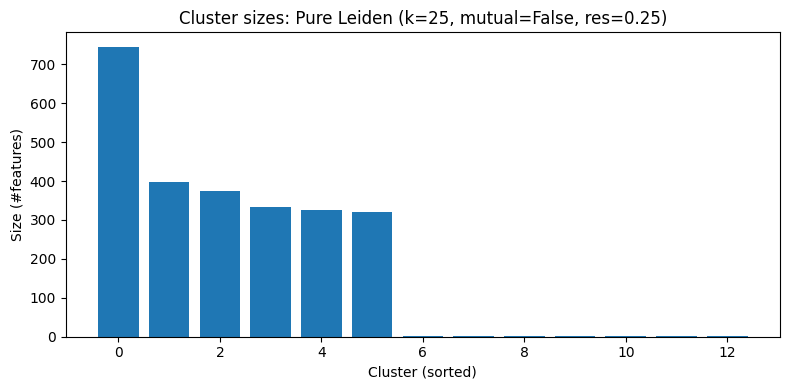

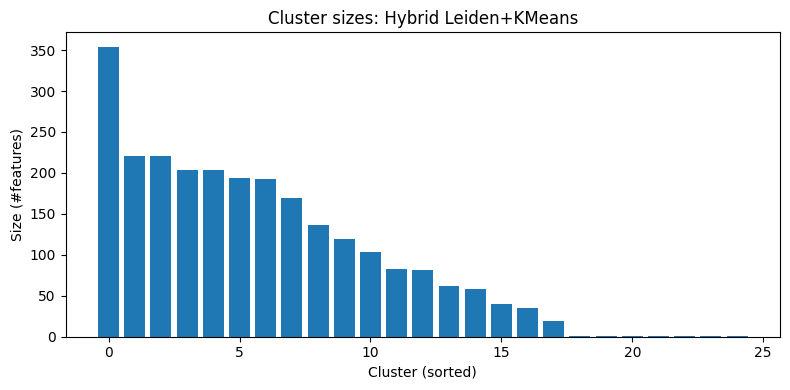

In [ ]:
import matplotlib.pyplot as plt

def cluster_sizes(labels):
    _, counts = np.unique(labels, return_counts=True)
    return np.sort(counts)[::-1]

sizes_leiden = cluster_sizes(labels_leiden_best)
sizes_hybrid = cluster_sizes(labels_hybrid_best)


plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(sizes_leiden)), sizes_leiden)
plt.xlabel("Cluster (sorted)")
plt.ylabel("Size (#features)")
plt.title("Cluster sizes: Pure Leiden (k=25, mutual=False, res=0.25)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(sizes_hybrid)), sizes_hybrid)
plt.xlabel("Cluster (sorted)")
plt.ylabel("Size (#features)")
plt.title("Cluster sizes: Hybrid Leiden+KMeans")
plt.tight_layout()
plt.show()


### Step 11: Squash embeddings down to 2D with UMAP

UMAP lets us take the high-dimensional GNN embeddings and project them onto a 2D plane while keeping similar points close together. This makes it easy to visualize whether our clusters actually form coherent groups in embedding space.

In [ ]:
#!pip install umap-learn
from umap import UMAP

umap = UMAP(n_components=2, random_state=0)
emb_2d = umap.fit_transform(emb_best)

x, y = emb_2d[:, 0], emb_2d[:, 1]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Step 12: Visualize both clusterings in 2D space

Now we can see the clusters. Left plot: pure Leiden colors. Right plot: hybrid Leiden+KMeans colors. If the colors form distinct blobs, that's good - it means the clustering makes sense in embedding space. If colors are all mixed up, the clusters might not be very meaningful.

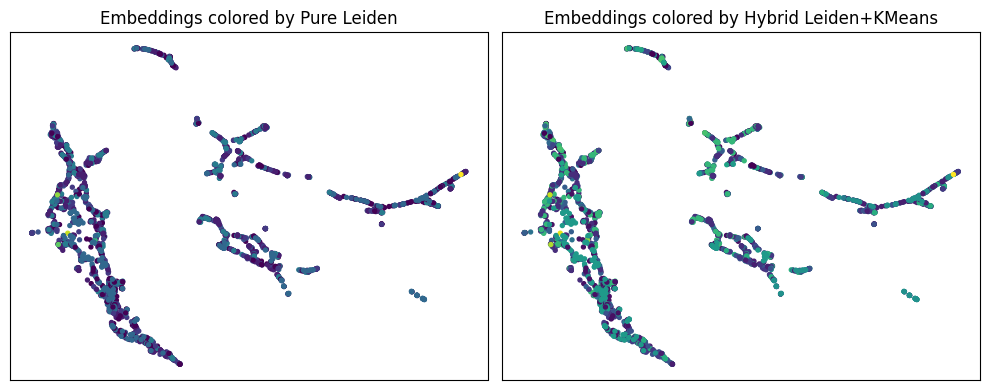

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(x, y, c=labels_leiden_best, s=8)
plt.title("Embeddings colored by Pure Leiden")
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
plt.scatter(x, y, c=labels_hybrid_best, s=8)
plt.title("Embeddings colored by Hybrid Leiden+KMeans")
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()


## Visualize gene embeddings with  UMAP.
- Overall method is same but the hybrid method refines the large mixed communited produced by pure leiden into smaller more localized modules.

/tmp/ipython-input-970235259.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap("tab20", len(unique))


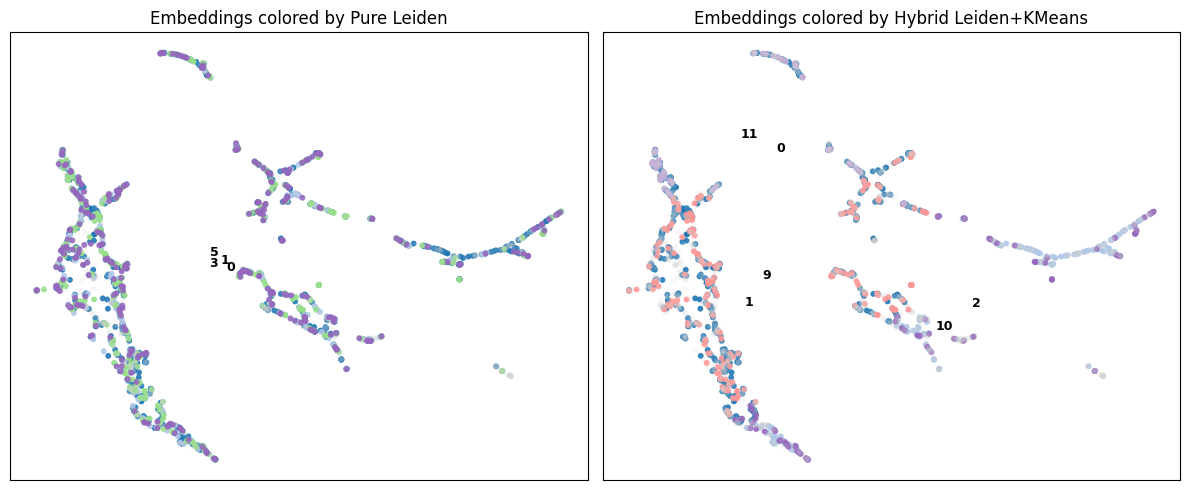

In [ ]:
def plot_umap_clusters(x, y, labels, title, highlight=None):
    x = np.asarray(x)
    y = np.asarray(y)
    labels = np.asarray(labels)

    if highlight is not None:
        highlight = set(highlight)

    unique = np.unique(labels)
    base_cmap = plt.cm.get_cmap("tab20", len(unique))

    for i, cid in enumerate(unique):
        mask = labels == cid

        # color + alpha depending on whether it's highlighted
        if highlight is None or cid in highlight:
            color = base_cmap(i % base_cmap.N)
            alpha = 0.9
        else:
            color = "lightgrey"
            alpha = 0.15

        plt.scatter(
            x[mask],
            y[mask],
            s=18,
            color=color,
            alpha=alpha,
            edgecolors="none",
        )

        # only label highlighted clusters
        if highlight is None or cid in highlight:
            cx, cy = x[mask].mean(), y[mask].mean()
            plt.text(cx, cy, str(cid), fontsize=9, weight="bold")

    plt.title(title)
    plt.xticks([]); plt.yticks([])

plt.figure(figsize=(12, 5))
pure_pam50_clusters = [0, 1, 3, 5]
hybrid_pam50_clusters = [0, 1, 2, 9, 10, 16]

plt.subplot(1, 2, 1)
plot_umap_clusters(
    x, y, labels_leiden_best,
    title="Embeddings colored by Pure Leiden",
    highlight=pure_pam50_clusters,
)

plt.subplot(1, 2, 2)
plot_umap_clusters(
    x, y, labels_hybrid_best,
    title="Embeddings colored by Hybrid Leiden+KMeans",
    highlight=hybrid_pam50_clusters,
)

plt.tight_layout()
plt.show()



## Step 13: Check modularity scores

Modularity measures how well the clusters respect the graph structure. Basically: are there way more edges within clusters than between clusters? Higher is better.

Pure Leiden optimizes modularity directly, so it should score well. The hybrid method might score lower because it's also trying to respect the embedding space, not just the graph.

In [ ]:
from networkx.algorithms import community

def nx_modularity(G, labels, nodes=None):
    # labels: array of cluster IDs aligned with nodes_best
    if nodes is None:
        nodes = list(G.nodes())
    clusters = {}
    for node, c in zip(nodes_best, labels):
        clusters.setdefault(c, []).append(node)
    communities = [set(v) for v in clusters.values()]
    return community.modularity(G, communities, weight="weight")
mod_pure_nx = nx_modularity(G_best, labels_leiden_best, nodes_best)
mod_hybrid_nx = nx_modularity(G_best, labels_hybrid_best, nodes_best)
print("NX modularity pure:", mod_pure_nx)
print("NX modularity hybrid:", mod_hybrid_nx)


NX modularity pure: 0.7228158802787285
NX modularity hybrid: 0.3144435383238925


## Step 15: How tight are the clusters in embedding space?

Two metrics:
- **Silhouette score**: Do points stick close to their cluster and far from others? Higher is better (ranges -1 to 1).
- **Davies-Bouldin index**: Ratio of within-cluster spread to between-cluster separation. Lower is better.

We'll filter out tiny clusters (< 2 members) to avoid division by zero. These metrics tell us if the clusters make sense geometrically, complementing the graph-based modularity measure.

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def filter_small_clusters(X, labels, min_size=2):
    labels = np.asarray(labels)
    X = np.asarray(X)
    _, counts = np.unique(labels, return_counts=True)
    big_clusters = {c for c, cnt in zip(*np.unique(labels, return_counts=True))
                    if cnt >= min_size}
    mask = np.array([l in big_clusters for l in labels])
    return X[mask], labels[mask]

# Embedding space
X_emb = emb_best

X_pure,   lab_pure = filter_small_clusters(X_emb, labels_leiden_best, min_size=2)
X_hybrid, lab_hybrid = filter_small_clusters(X_emb, labels_hybrid_best, min_size=2)

sil_pure = silhouette_score(X_pure, lab_pure)
sil_hybrid = silhouette_score(X_hybrid, lab_hybrid)

db_pure = davies_bouldin_score(X_pure, lab_pure)
db_hybrid = davies_bouldin_score(X_hybrid, lab_hybrid)

print("Silhouette (embedding) pure:",   sil_pure)
print("Silhouette (embedding) hybrid:", sil_hybrid)
print("Davies-Bouldin (embedding) pure:",   db_pure)
print("Davies-Bouldin (embedding) hybrid:", db_hybrid)


Silhouette (embedding) pure: -0.100749515
Silhouette (embedding) hybrid: -0.11799618
Davies-Bouldin (embedding) pure: 26.599313130042038
Davies-Bouldin (embedding) hybrid: 18.648377126469413


## Step 16: Do clusters group genes with similar expression?

So far we've looked at cluster quality in the learned embedding space. But what about the original expression data? Let's compute silhouette score using raw expression profiles (genes x patients). If it's high, our clusters are grouping genes that actually behave similarly across patients - a good biological sign.

In [ ]:
# Expression-space representations for features
X_expr = merged_brca.T.loc[nodes_best].to_numpy() # features x patients

X_pure_expr, lab_pure_expr = filter_small_clusters(X_expr, labels_leiden_best)
X_hybrid_expr, lab_hybrid_expr = filter_small_clusters(X_expr, labels_hybrid_best)

sil_pure_expr = silhouette_score(X_pure_expr, lab_pure_expr)
sil_hybrid_expr = silhouette_score(X_hybrid_expr, lab_hybrid_expr)

print("Silhouette (expression) - pure:",   sil_pure_expr)
print("Silhouette (expression) - hybrid:", sil_hybrid_expr)


Silhouette (expression) - pure: 0.04171223979236426
Silhouette (expression) - hybrid: -0.10730011596006579


## Step 17: Do these clusters relate to known breast cancer subtypes?

Here's where we see if the clustering found anything biologically meaningful. For each cluster, we'll:
1. Calculate a "module eigengene" - basically the main expression pattern of that cluster across all patients
2. Test whether this pattern differs significantly across PAM50 subtypes (Luminal A, Luminal B, Basal, Her2, Normal) using ANOVA

Clusters with low p-values are the interesting ones - they capture expression patterns that distinguish cancer subtypes. We only look at clusters with 5+ genes to keep the statistics stable.

In [ ]:
from sklearn.decomposition import PCA
import scipy.stats as stats

# Make a DataFrame of labels aligned with features
cluster_df = pd.DataFrame({
    "feature": nodes_best,
    "cluster_hybrid": labels_hybrid_best,
})
cluster_df.set_index("feature", inplace=True)

subtypes = pam50.iloc[:, 0] # "LumA", "LumB", etc.

def module_eigengene(features):
    # features: list of feature names
    X = merged_brca[features]
    # center features
    X_centered = X - X.mean(axis=0)
    pca = PCA(n_components=1)
    eig = pca.fit_transform(X_centered)[:, 0]  # (patients,)
    return pd.Series(eig, index=merged_brca.index)

results = []

for c_id in sorted(cluster_df["cluster_hybrid"].unique()):
    feats = cluster_df.index[cluster_df["cluster_hybrid"] == c_id].tolist()
    if len(feats) < 5:
        continue  # skip tiny modules

    eig = module_eigengene(feats)

    # ANOVA across PAM50 subtypes
    groups = [eig[subtypes == s] for s in subtypes.unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    results.append((c_id, len(feats), f_stat, p_val))

res_df = pd.DataFrame(results, columns=["cluster_id", "size", "Fstat", "pval"]).sort_values("pval")
print(res_df.head(10))


    cluster_id  size       Fstat           pval
9            9   192  965.340369  5.768083e-297
10          10    83  953.361194  3.074354e-295
11          11    58  885.518009  4.180510e-285
8            8    62  417.807245  1.269612e-190
7            7   194  375.503341  1.087896e-178
6            6   119  296.025048  1.196348e-153
0            0   170  251.595717  8.293693e-138
2            2   221  251.142951  1.225213e-137
16          16   204  215.932914  6.699253e-124
1            1   354  191.598068  1.073947e-113


## Step 18: Same analysis for pure Leiden

Let's run the exact same biological validation on the pure Leiden clusters. This way we can compare: does the hybrid refinement help us find more biologically meaningful groups, or does it just split up stuff that was already good?

In [ ]:
from sklearn.decomposition import PCA
import scipy.stats as stats

# Make a DataFrame of labels aligned with columns (features) for pure leiden
cluster_df = pd.DataFrame({
    "feature": nodes_best,
    "cluster_pure": labels_leiden_best,
})
cluster_df.set_index("feature", inplace=True)

subtypes = pam50.iloc[:, 0]   # "LumA", "LumB", etc.

def module_eigengene(features):
    # features: list of feature names
    X = merged_brca[features]
    # center features
    X_centered = X - X.mean(axis=0)
    pca = PCA(n_components=1)
    eig = pca.fit_transform(X_centered)[:, 0]  # (patients,)
    return pd.Series(eig, index=merged_brca.index)

results = []

for c_id in sorted(cluster_df["cluster_pure"].unique()):
    feats = cluster_df.index[cluster_df["cluster_pure"] == c_id].tolist()
    if len(feats) < 5:
        continue  # skip tiny modules

    eig = module_eigengene(feats)

    # ANOVA across PAM50 subtypes
    groups = [eig[subtypes == s] for s in subtypes.unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    results.append((c_id, len(feats), f_stat, p_val))

res_df = pd.DataFrame(results, columns=["cluster_id", "size", "Fstat", "pval"]).sort_values("pval")
print(res_df.head(10))


   cluster_id  size        Fstat           pval
3           3   333  1016.777669  3.502392e-304
2           2   375   373.604309  3.916626e-178
0           0   745   225.045740  1.445919e-127
5           5   320   195.410558  2.456061e-115
1           1   397   125.348165   2.981741e-82
4           4   326   104.716946   4.115628e-71


In [ ]:
print(len(np.unique(labels_leiden_best)))
print(len(np.unique(labels_hybrid_best)))


13
25


## Step 19: Are genes in the same cluster actually correlated?

Another way to check cluster quality: calculate the average correlation between genes within the same cluster vs genes in different clusters. Good clustering should give us high correlation within, low correlation between.

In [ ]:
def avg_corr_within_between(labels):
    labels = np.asarray(labels)
    X = merged_brca.T.loc[nodes_best].to_numpy()  # features x patients
    C = np.corrcoef(X)  # feature-feature correlation

    same = []
    diff = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if np.isnan(C[i, j]):
                continue
            if labels[i] == labels[j]:
                same.append(C[i, j])
            else:
                diff.append(C[i, j])

    return np.mean(same), np.mean(diff)

w_pure, b_pure   = avg_corr_within_between(labels_leiden_best)
w_hybrid, b_hybrid = avg_corr_within_between(labels_hybrid_best)

print("Pure Leiden:   avg within =", w_pure, " avg between =", b_pure)
print("Hybrid Leiden: avg within =", w_hybrid, " avg between =", b_hybrid)


Pure Leiden:   avg within = 0.2112299158484095  avg between = -0.007768855357243913
Hybrid Leiden: avg within = 0.22075701996630706  avg between = 0.017793906195944575


### Quick look at cluster assignments

Just printing the first few rows to see the structure. Each feature gets a cluster ID.

In [ ]:
print(cluster_df.head())

              cluster_pure
feature                   
CPB1_1360                3
TFF1_7031                3
MUCL1_118430             0
PRAME_23532              0
KCNJ3_3760               3


## Step 20: Does the top cluster contain known PAM50 marker genes? (Go back and run Step 17 then go ahead and run it)

Let's dig into the cluster with the lowest p-value (strongest association with subtypes). We'll check which PAM50 genes; the 50 well-established breast cancer markers from the literature show up in this module.

If we find a bunch of PAM50 genes here, that's strong validation that our clustering is recovering real biological signal, not just noise.

In [ ]:
c_star = res_df.sort_values("pval").iloc[0]["cluster_id"]
feats_star = cluster_df.index[cluster_df["cluster_hybrid"] == c_star].tolist()
print("Cluster", c_star, "size:", len(feats_star))
print("Some features:", feats_star[:20])
#print(pam50)
def feature_symbols(features):
    return {f.split("_")[0] for f in features}

# a list of PAM50 genes taken from literature:
pam50_genes = set(["UBE2T", "BIRC5", "NUF2",
"CDC6","CCNB1","TYMS","MYBL2","CEP55","MELK","NDC80","RRM2","UBE2C","CENPF","PTTG1","EXO1","ORC6L","ORC6","ANLN","CCNE1","CDC20","MKI67","KIF2C","ACTR3B","MYC","EGFR","KRT5","PHGDH","CDH3","MIA","KRT17","FOXC1","SFRP1","KRT14","ESR1","SLC39A6","BAG1","MAPT","PGR","CXXC5",
"MLPH","BCL2","MDM2","NAT1","FOXA1","BLVRA","MMP11","GPR160","FGFR4","GRB7","TMEM45B",
"ERBB2"])
overlap = pam50_genes.intersection(feature_symbols(feats_star))
print("PAM50 genes in this module:", overlap)


Cluster 9.0 size: 192
Some features: ['CPB1_1360', 'TFF1_7031', 'KCNJ3_3760', 'CYP2B7P1_1556', 'CYP4Z1_199974', 'TFF3_7033', 'ABCC11_85320', 'NPY1R_4886', 'CYP4Z2P_163720', 'ASCL1_429', 'CST9_128822', 'KLHDC7A_127707', 'PTPRT_11122', 'NXPH1_30010', 'SERPINA11_256394', 'EEF1A2_1917', 'SORCS1_114815', 'ESR1_2099', 'SLC7A4_6545', 'CAPN8_388743']
PAM50 genes in this module: {'MAPT', 'ESR1', 'NAT1', 'MLPH', 'BCL2', 'SLC39A6'}


## Step 21: Check PAM50 enrichment across top clusters (Make sure to go back and run Step 17 then run it)

Now let's systematically check the top 10 clusters. How many PAM50 genes does each one capture? Are different clusters picking up different subtype markers (e.g., one cluster for Luminal genes, another for Basal)?

This tells us whether the hybrid method is splitting biology in a meaningful way.

In [ ]:
for _, row in res_df.sort_values("pval").head(10).iterrows():
    c_id = row["cluster_id"]
    feats = cluster_df.index[cluster_df["cluster_hybrid"] == c_id].tolist()
    overlap = pam50_genes & feature_symbols(feats)
    print(f"Cluster {int(c_id)}: size={len(feats)}, PAM50 overlap={overlap}")


Cluster 9: size=192, PAM50 overlap={'MAPT', 'ESR1', 'NAT1', 'MLPH', 'BCL2', 'SLC39A6'}
Cluster 10: size=83, PAM50 overlap={'FOXA1', 'PGR'}
Cluster 11: size=58, PAM50 overlap=set()
Cluster 8: size=62, PAM50 overlap=set()
Cluster 7: size=194, PAM50 overlap=set()
Cluster 6: size=119, PAM50 overlap=set()
Cluster 0: size=170, PAM50 overlap={'SFRP1', 'MKI67', 'ANLN', 'CEP55', 'KRT14', 'PHGDH'}
Cluster 2: size=221, PAM50 overlap={'CDC6', 'EGFR', 'KRT17', 'RRM2', 'NDC80', 'EXO1', 'BIRC5'}
Cluster 16: size=204, PAM50 overlap={'MIA'}
Cluster 1: size=354, PAM50 overlap={'MYBL2', 'CCNE1', 'ORC6L', 'CDH3', 'GRB7', 'KIF2C', 'NUF2', 'MELK', 'CDC20', 'KRT5', 'FOXC1', 'ERBB2'}


### Step 21.5: Same check for pure Leiden (re-run step 18 then this step)

Running the same PAM50 enrichment on pure Leiden clusters to see how they compare. Maybe pure Leiden already does a good job and doesn't need refinement. Or maybe hybrid separates mixed signals better. Let's find out.

In [ ]:
for _, row in res_df.sort_values("pval").head(10).iterrows():
    c_id = row["cluster_id"]
    feats = cluster_df.index[cluster_df["cluster_pure"] == c_id].tolist()
    overlap = pam50_genes & feature_symbols(feats)
    print(f"Cluster {int(c_id)}: size={len(feats)}, PAM50 overlap={overlap}")

Cluster 3: size=333, PAM50 overlap={'MAPT', 'FOXA1', 'ESR1', 'NAT1', 'MLPH', 'PGR', 'BCL2', 'SLC39A6'}
Cluster 2: size=375, PAM50 overlap=set()
Cluster 0: size=745, PAM50 overlap={'RRM2', 'ANLN', 'PHGDH', 'BIRC5', 'EGFR', 'CDH3', 'GRB7', 'KRT5', 'FOXC1', 'KRT14', 'ERBB2', 'MYBL2', 'SFRP1', 'CDC6', 'MKI67', 'ORC6L', 'CEP55', 'CCNE1', 'KRT17', 'KIF2C', 'NUF2', 'MELK', 'CDC20', 'NDC80', 'EXO1'}
Cluster 5: size=320, PAM50 overlap={'MIA'}
Cluster 1: size=397, PAM50 overlap={'NAT1', 'MYBL2', 'ESR1'}
Cluster 4: size=326, PAM50 overlap=set()


# Section 2 - BRCA Patient Clustering: Leiden vs Spectral

This notebook evaluates patient-level clustering on the TCGA-BRCA multi-omics data
using BioNeuralNet. We:

1. Load BRCA multi-omics (RNA, methylation, miRNA).
2. Build a patient-patient kNN similarity graph.
3. Compute patient embeddings with PCA.
4. Run Leiden (pure + KMeans refinement) and Spectral clustering.
5. Evaluate with ARI, NMI, silhouette.
6. Perform simple clinical validation via BRCA subtype.


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
)

from bioneuralnet.datasets import DatasetLoader
from bioneuralnet.utils import select_top_k_variance
from bioneuralnet.utils.graph import gen_similarity_graph




## Step 1: Pull BRCA multi-omics and subtype labels into one workspace

This step just checks shapes and schema so we know exactly what our patient × omics tables and label table look like before we start building graphs and embeddings.


In [ ]:
from bioneuralnet.clustering import Spectral_Clustering

# Load BRCA dataset
brca = DatasetLoader("brca")
print("BRCA table shapes:", brca.shape)

rna   = brca.data["rna"]     # patients x genes
meth  = brca.data["meth"]    # patients x CpGs
mirna = brca.data["mirna"]   # patients x miRNAs

# Supervised labels (integer-encoded BRCA subtypes, 0–4)
target_df = brca.data["target"]          # columns: ["patient", "target"]
print("target_df shape:", target_df.shape)
print("target_df index name:", target_df.index.name)
print("target_df columns:", target_df.columns)


# Simple feature selection on RNA and meth; keep all miRNA
rna_sel   = select_top_k_variance(rna,  k=1000)
meth_sel  = select_top_k_variance(meth, k=1000)
mirna_sel = mirna

# Merge omics along columns: patients x features
merged_brca = pd.concat([rna_sel, meth_sel, mirna_sel], axis=1)
print("merged_brca shape:", merged_brca.shape)  # (N_patients, D_features)

BRCA table shapes: {'mirna': (769, 503), 'target': (769, 1), 'clinical': (769, 103), 'rna': (769, 2500), 'meth': (769, 2203)}
target_df shape: (769, 1)
target_df index name: patient
target_df columns: Index(['target'], dtype='object')


2025-12-05 06:25:13,261 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
INFO:bioneuralnet.utils.preprocess:[Inf]: Replaced 0 infinite values
2025-12-05 06:25:13,263 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
INFO:bioneuralnet.utils.preprocess:[NaN]: Replaced 0 NaNs after median imputation
2025-12-05 06:25:13,264 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
INFO:bioneuralnet.utils.preprocess:[Zero-Var]: 0 columns dropped due to zero variance
2025-12-05 06:25:13,292 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
INFO:bioneuralnet.utils.preprocess:Selected top 1000 features by variance
2025-12-05 06:25:15,318 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
INFO:bioneuralnet.utils.preprocess:[Inf]: Replaced 0 infinite values
2025-12-05 06:25:15,321 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs af

merged_brca shape: (769, 2503)


### Step 3: Build patient-patient similarity graph

Standardize features, then build a k-NN graph where each patient connects to their 15 most similar neighbors (cosine distance).

In [ ]:
# Standardize features across patients (zero mean, unit variance per feature)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_brca.values)
merged_brca_scaled = pd.DataFrame(
    X_scaled,
    index=merged_brca.index,
    columns=merged_brca.columns,
)
print("merged_brca_scaled shape:", merged_brca_scaled.shape)

# Build cosine kNN graph among patients
# We call gen_similarity_graph on (features x patients), so we transpose.
A_pat = gen_similarity_graph(
    merged_brca_scaled.T,  # rows = features, cols = patients, similarity among patients
    k=15,
    metric="cosine",
    mutual=True,
    self_loops=False,
)

if isinstance(A_pat, pd.DataFrame):
    print("A_pat index (first 5):", A_pat.index[:5])
    print("A_pat columns (first 5):", A_pat.columns[:5])
    G_pat = nx.from_pandas_adjacency(A_pat)
else:
    G_pat = nx.from_scipy_sparse_array(A_pat)

print("Patient graph:", G_pat.number_of_nodes(), "nodes,", G_pat.number_of_edges(), "edges")
patients_order = list(G_pat.nodes())
print("First 5 patients:", patients_order[:5])


merged_brca_scaled shape: (769, 2503)
A_pat index (first 5): Index(['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK',
       'TCGA-4H-AAAK'],
      dtype='object', name='patient')
A_pat columns (first 5): Index(['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK',
       'TCGA-4H-AAAK'],
      dtype='object', name='patient')
Patient graph: 769 nodes, 2580 edges
First 5 patients: ['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK', 'TCGA-4H-AAAK']


### Step 4: Generate patient embeddings with PCA

Reduce the multi-omics features to 16 dimensions using PCA.

In [ ]:
# Patient embeddings: PCA on standardized multi-omics features
X_pat = merged_brca_scaled.loc[patients_order].values  # align with graph node order

pca = PCA(n_components=16, random_state=0)
emb_pat = pca.fit_transform(X_pat)

print("Patient embedding shape:", emb_pat.shape)

Patient embedding shape: (769, 16)


### Step 5: Prepare ground truth labels

Map integer-coded subtypes to names (LumA, Her2, LumB, Basal, Normal) for easier interpretation.

In [ ]:
# Align integer subtype labels to patients_order
subtypes = target_df.loc[patients_order, "target"].values
K = np.unique(subtypes).size
print("Unique subtype classes:", np.unique(subtypes), " (K =", K, ")")

id2subtype = {
    0: "LumA",
    1: "Her2",
    2: "LumB",
    3: "Basal",
    4: "Normal",
}
subtypes_named = pd.Series(subtypes, index=patients_order).map(id2subtype)
subtypes_named.value_counts()


Unique subtype classes: [0 1 2 3 4]  (K = 5 )


,count
LumA,419
LumB,140
Basal,130
Her2,46
Normal,34


### Step 6: Run Leiden clustering

Try both pure Leiden and the hybrid version (Leiden + KMeans refinement) on the patient graph.

In [ ]:
# Leiden clustering on patient graph
from bioneuralnet.clustering import Leiden
lc_pat = Leiden(
    G=G_pat,
    embeddings=emb_pat,
    use_edge_weights=True,
    resolution=0.04,
    random_state=0,
)

labels_pat_pure   = lc_pat.run(refine_with_kmeans=False)
labels_pat_hybrid = lc_pat.run(refine_with_kmeans=True, max_k_per_community=3)

print("Leiden (pure) clusters:   ", np.unique(labels_pat_pure).size)
print("Leiden+KMeans clusters:   ", np.unique(labels_pat_hybrid).size)
print("Leiden modularity quality:", lc_pat.modularity_)


2025-12-05 06:25:30,095 - bioneuralnet.clustering.leiden - INFO - Built igraph from NetworkX: 769 nodes, 2580 edges, directed=False, use_edge_weights=True, weights_effective=yes.
INFO:bioneuralnet.clustering.leiden:Built igraph from NetworkX: 769 nodes, 2580 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-05 06:25:30,128 - bioneuralnet.clustering.leiden - INFO - Leiden found 49 communities on 769 nodes (resolution=0.04).
INFO:bioneuralnet.clustering.leiden:Leiden found 49 communities on 769 nodes (resolution=0.04).
2025-12-05 06:25:30,165 - bioneuralnet.clustering.leiden - INFO - Hybrid Leiden+KMeans produced 53 clusters (base communities: 49).
INFO:bioneuralnet.clustering.leiden:Hybrid Leiden+KMeans produced 53 clusters (base communities: 49).


Leiden (pure) clusters:    49
Leiden+KMeans clusters:    53
Leiden modularity quality: 705.0508699195468


### Step 7: Run spectral clustering

Run spectral clustering with K set to the number of known subtypes (5) for direct comparison.

In [ ]:
# Spectral clustering on the same patient graph, with K = number of subtypes
spectral_cluster_graph = Spectral_Clustering(
    G=G_pat,
    n_clusters=K,
    use_edge_weights=True,
    random_state=0,
)
labels_spec, nodes_spec = spectral_cluster_graph.run()

# node order should match patients_order
assert list(nodes_spec) == patients_order, "Node order mismatch between spectral and patient list!"

print("Spectral clusters:", np.unique(labels_spec).size)

2025-12-05 06:25:33,935 - bioneuralnet.clustering.spectral - INFO - Running SpectralClustering on graph with 769 nodes, 2580 edges, n_clusters=5, use_edge_weights=True.
INFO:bioneuralnet.clustering.spectral:Running SpectralClustering on graph with 769 nodes, 2580 edges, n_clusters=5, use_edge_weights=True.


Spectral clusters: 5


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


### Step 8: Check graph connectivity

Verify the graph structure - how many connected components exist and what are their sizes?

In [ ]:
comps = sorted(nx.connected_components(G_pat), key=len, reverse=True)
sizes = [len(c) for c in comps]
print("Number of connected components:", len(comps))
print("Sizes of first 10 components:", sizes[:10])
print("Sum of sizes:", sum(sizes))

Number of connected components: 48
Sizes of first 10 components: [715, 3, 2, 2, 2, 2, 2, 1, 1, 1]
Sum of sizes: 769


### Step 9: Compare clustering quality

Measure how well each method recovers known subtypes (ARI, NMI) and cluster tightness in PCA space (silhouette).

In [ ]:
def eval_clusters(y_true, y_pred, name):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    print(f"{name:20s} ARI={ari:.3f}, NMI={nmi:.3f}")
    return ari, nmi

print(" External metrics vs subtype labels (target)")
ari_lp, nmi_lp   = eval_clusters(subtypes, labels_pat_pure,   "Leiden (pure)")
ari_lh, nmi_lh   = eval_clusters(subtypes, labels_pat_hybrid, "Leiden+KMeans")
ari_sp, nmi_sp   = eval_clusters(subtypes, labels_spec,       "Spectral (k=K)")

print("\n Silhouette in embedding space (PCA)")
sil_leiden = silhouette_score(emb_pat, labels_pat_pure)
sil_spec   = silhouette_score(emb_pat, labels_spec)

print(f"Silhouette - Leiden (pure): {sil_leiden:.3f}")
print(f"Silhouette - Spectral:      {sil_spec:.3f}")

 External metrics vs subtype labels (target)
Leiden (pure)        ARI=0.295, NMI=0.390
Leiden+KMeans        ARI=0.143, NMI=0.315
Spectral (k=K)       ARI=0.288, NMI=0.385

 Silhouette in embedding space (PCA)
Silhouette - Leiden (pure): -0.379
Silhouette - Spectral:      -0.138


### Step 10: Cross-tabulate clusters vs subtypes

For each method, show which clusters contain which subtypes (rows = clusters, columns = subtypes).

In [ ]:
def cluster_subtype_table(labels, subtypes_named, name, normalize=True):
    df_ct = pd.DataFrame(
        {"cluster": labels, "subtype": subtypes_named},
        index=patients_order,
    )
    ctab = pd.crosstab(
        df_ct["cluster"],
        df_ct["subtype"],
        normalize="index" if normalize else None,
    )
    print(f"\n {name}: cluster x subtype table")
    display(ctab)
    return ctab

ct_lp = cluster_subtype_table(labels_pat_pure,   subtypes_named, "Leiden (pure)")
ct_lh = cluster_subtype_table(labels_pat_hybrid, subtypes_named, "Leiden+KMeans")
ct_sp = cluster_subtype_table(labels_spec,       subtypes_named, "Spectral (k=K)")


 Leiden (pure): cluster x subtype table


subtype,Basal,Her2,LumA,LumB,Normal
cluster,,,,,
0,0.020000,0.073333,0.648333,0.213333,0.045000
1,0.956522,0.000000,0.000000,0.000000,0.043478
2,0.000000,0.000000,1.000000,0.000000,0.000000
3,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,1.000000,0.000000
5,0.000000,0.000000,1.000000,0.000000,0.000000
6,0.000000,0.000000,1.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,1.000000,0.000000
8,0.000000,0.000000,1.000000,0.000000,0.000000



 Leiden+KMeans: cluster x subtype table


subtype,Basal,Her2,LumA,LumB,Normal
cluster,,,,,
0,0.000000,0.024096,0.644578,0.331325,0.000000
1,0.041045,0.119403,0.660448,0.082090,0.097015
2,0.006024,0.048193,0.632530,0.307229,0.006024
3,0.958333,0.000000,0.000000,0.000000,0.041667
4,1.000000,0.000000,0.000000,0.000000,0.000000
5,0.928571,0.000000,0.000000,0.000000,0.071429
6,0.000000,0.000000,1.000000,0.000000,0.000000
7,0.000000,0.000000,1.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,1.000000,0.000000



 Spectral (k=K): cluster x subtype table


subtype,Basal,Her2,LumA,LumB,Normal
cluster,,,,,
0,0.956522,0.000000,0.00000,0.000000,0.043478
1,0.031008,0.071318,0.63876,0.213953,0.044961
2,0.000000,0.000000,0.50000,0.500000,0.000000
3,0.000000,0.000000,1.00000,0.000000,0.000000
4,0.000000,0.000000,1.00000,0.000000,0.000000


### Step 11: Calculate cluster purity

Purity = what fraction of each cluster belongs to its dominant subtype? Higher purity means cleaner separation.

In [ ]:
def cluster_purity_table(labels, y_true_named, name):
    df = pd.DataFrame({"cluster": labels, "subtype": y_true_named})
    ctab = pd.crosstab(df["cluster"], df["subtype"], normalize="index")
    purity = ctab.max(axis=1)                   # per-cluster purity
    sizes = df["cluster"].value_counts().sort_index()
    micro = (purity * sizes).sum() / sizes.sum()  # size-weighted purity
    macro = purity.mean()                        # average cluster purity
    print(f"{name}: micro-purity={micro:.3f}, macro-purity={macro:.3f}")
    return ctab, purity

print("Cluster purity summary ")
ct_spec, purity_spec = cluster_purity_table(labels_spec,       subtypes_named, "Spectral")
ct_lp,   purity_lp   = cluster_purity_table(labels_pat_pure,   subtypes_named, "Leiden (pure)")
ct_lh,   purity_lh   = cluster_purity_table(labels_pat_hybrid, subtypes_named, "Leiden+KMeans")

Cluster purity summary 
Spectral: micro-purity=0.688, macro-purity=0.819
Leiden (pure): micro-purity=0.719, macro-purity=0.992
Leiden+KMeans: micro-purity=0.719, macro-purity=0.978


### Step 12: Visualize spectral clusters on the graph

Draw the patient graph with nodes colored by spectral cluster assignment.

/tmp/ipython-input-936343731.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", n_clusters)


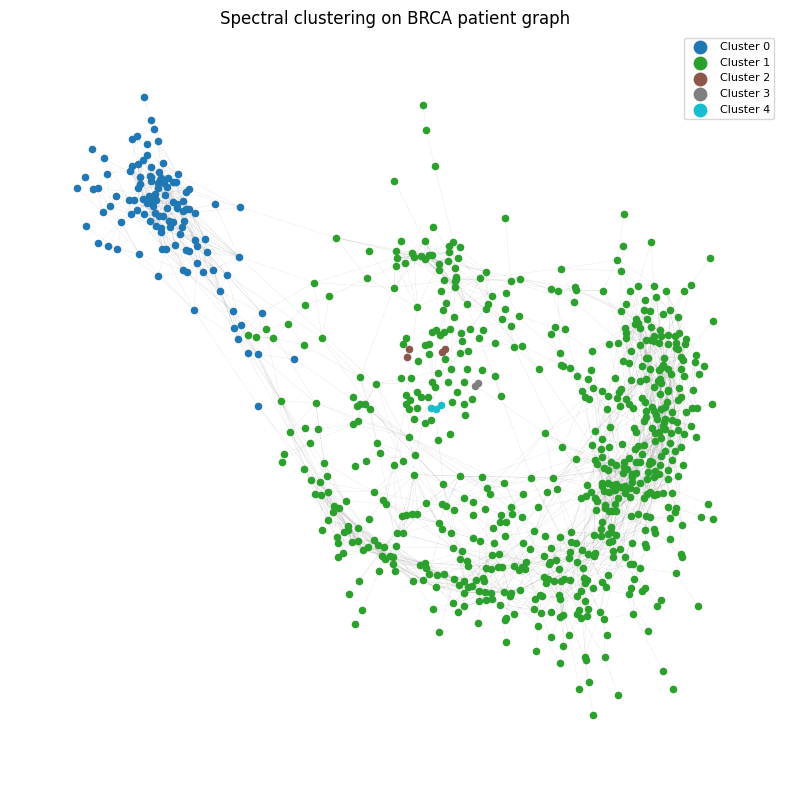

In [ ]:
import matplotlib.pyplot as plt

# Unique spectral clusters
unique_clusters = np.unique(labels_spec)
n_clusters = unique_clusters.size

# Layout for the patient graph
pos = nx.spring_layout(G_pat, seed=0)

# Color map for clusters
cmap = plt.cm.get_cmap("tab10", n_clusters)

plt.figure(figsize=(8, 8))

for i, c in enumerate(unique_clusters):
    # nodes in this cluster
    nodes_c = [node for node, lab in zip(patients_order, labels_spec) if lab == c]
    nx.draw_networkx_nodes(
        G_pat,
        pos,
        nodelist=nodes_c,
        node_size=20,
        node_color=[cmap(i)],
        label=f"Cluster {c}",
    )

# Draw edges lightly in the background
nx.draw_networkx_edges(G_pat, pos, alpha=0.1, width=0.3)

plt.axis("off")
plt.title("Spectral clustering on BRCA patient graph")
plt.legend(markerscale=2, fontsize=8, loc="best")
plt.tight_layout()
plt.show()

### Step 13: Visualize spectral clusters in PCA space

Plot patients in 2D PCA space colored by spectral cluster to see if clusters are geometrically coherent.

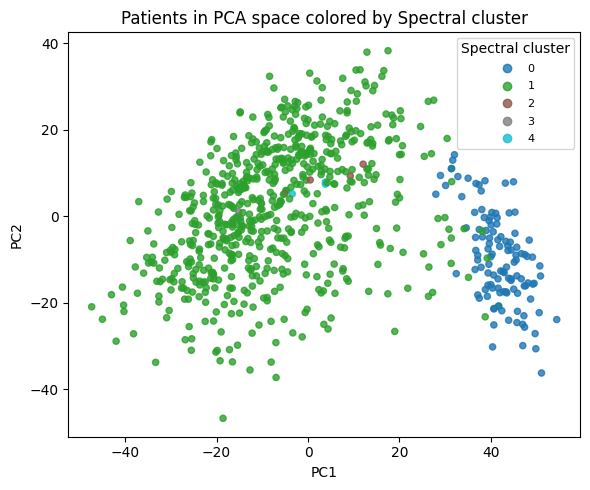

In [ ]:
unique_clusters = np.unique(labels_spec)

plt.figure(figsize=(6, 5))

scatter = plt.scatter(
    emb_pat[:, 0],
    emb_pat[:, 1],
    c=labels_spec,
    s=20,
    alpha=0.8,
    cmap="tab10",
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Patients in PCA space colored by Spectral cluster")
handles, labels = scatter.legend_elements(prop="colors")
plt.legend(handles, labels, title="Spectral cluster", fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
!pip freeze > requirements.text